### Installation
The main ones are torch and hls4ml. Please install them using pip.

If you still get import errors and pip doesn't tell you why, please have a look at environment.yml. 

It lists all the python packages that I have used to make this code work. Not all the packages in the yml file are necessary, however. 

### Imports

The current hls4ml implementations does not support pytorch geometric(**pyg**). 
The starting code has been taken from Mr. Abd Elabd from Prof Javier Duarte's group. (Source: https://github.com/fastmachinelearning/hls4ml/tree/pyg_to_hls_rebase_w_dataflow)

This means that once you "pip install hls4ml" to your conda env, you have to replace it with
the local folder with the same name("hls4ml"), which supports pyg. 

To find the conda env package location, simply do:

In [1]:
import torch
torch.__file__

'/home/swissman777/anaconda3/envs/hls4ml/lib/python3.7/site-packages/torch/__init__.py'

The code above prints the location where my packages are installed. In my case, it was '/home/swissman777/anaconda3/envs/hls4ml/lib/python3.7/site-packages/torch/__init__.py', 

This means that my hls4ml package is located in '/home/swissman777/anaconda3/envs/hls4ml/lib/python3.7/site-packages/'

Please go to the site-packages, find the directory "hls4ml", **delete** it, and **replace** it with the "hls4ml" file that we have in this repo. That is the package that supports pyg

In [2]:
"""
import rest of the packages
"""
import os
import sys
import yaml
import argparse
import numpy as np
import torch
import torch.nn as nn

from hls4ml.utils.config import config_from_pyg_model
from hls4ml.converters import convert_from_pyg_model


from collections import OrderedDict
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

# locals
from utils.models.interaction_network_pyg import InteractionNetwork
from model_wrappers import model_wrapper
from utils.data.dataset_pyg import GraphDataset
from utils.data.fix_graph_size import fix_graph_size
import time
import pickle as pkl


handler args: ('NodeBlock',)
handler args: ('EdgeBlock',)
handler args: ('EdgeAggregate',)
handler args: ('ResidualBlock',)
handler args: ('NodeEncoder',)
handler args: ('EdgeEncoder',)
handler args: ('NodeEncoderBatchNorm1d',)
handler args: ('EdgeEncoderBatchNorm1d',)


### PyTorch Model

In [3]:
"""
We intialize our pyg model
"""
torch_model = InteractionNetwork(flow="source_to_target", out_channels=128).eval() # eval mode for batchnorm

In [4]:
"""
We obtain the state dict(trained parameters) from Siqi Miao, PhD student of Prof Pan Li
"""
state_dict = torch.load('./model.pt', map_location="cpu")
# state_dict

In [5]:
"""
transfer the state_dict into our pyg model
"""
torch_model.beta = state_dict['model_state_dict']['convs.0.t']
# print(type(torch_model.node_encoder.weight))
# print(type(siqi_model_state_dict['model_state_dict']['node_encoder.weight']))
torch_model.node_encoder.weight = nn.Parameter(state_dict['model_state_dict']['node_encoder.weight'])
torch_model.node_encoder.bias = nn.Parameter(state_dict['model_state_dict']['node_encoder.bias'])
torch_model.edge_encoder.weight = nn.Parameter(state_dict['model_state_dict']['edge_encoder.weight'])
torch_model.edge_encoder.bias = nn.Parameter(state_dict['model_state_dict']['edge_encoder.bias'])
torch_model.node_encoder_norm.weight = nn.Parameter(
    state_dict['model_state_dict']['bn_node_feature.weight']
)
torch_model.node_encoder_norm.norm.weight = torch_model.node_encoder_norm.weight # this is temporary soln to the structure of the class

torch_model.node_encoder_norm.bias = nn.Parameter(
    state_dict['model_state_dict']['bn_node_feature.bias']
)
torch_model.node_encoder_norm.norm.bias = torch_model.node_encoder_norm.bias # this is temporary soln to the structure of the class

torch_model.node_encoder_norm.running_mean = nn.Parameter(
    state_dict['model_state_dict']['bn_node_feature.running_mean']
)
torch_model.node_encoder_norm.norm.running_mean = torch_model.node_encoder_norm.running_mean # this is temporary soln to the structure of the class

torch_model.node_encoder_norm.running_var = nn.Parameter(
    state_dict['model_state_dict']['bn_node_feature.running_var']
)
torch_model.node_encoder_norm.norm.running_var = torch_model.node_encoder_norm.running_var # this is temporary soln to the structure of the class


torch_model.edge_encoder_norm.weight = nn.Parameter(
    state_dict['model_state_dict']['bn_edge_feature.weight']
)
torch_model.edge_encoder_norm.norm.weight = torch_model.edge_encoder_norm.weight # this is temporary soln to the structure of the class

torch_model.edge_encoder_norm.bias = nn.Parameter(
    state_dict['model_state_dict']['bn_edge_feature.bias']
)
torch_model.edge_encoder_norm.norm.bias = torch_model.edge_encoder_norm.bias # this is temporary soln to the structure of the class

torch_model.edge_encoder_norm.running_mean = nn.Parameter(
    state_dict['model_state_dict']['bn_edge_feature.running_mean']
)
torch_model.edge_encoder_norm.norm.running_mean = torch_model.edge_encoder_norm.running_mean # this is temporary soln to the structure of the class

torch_model.edge_encoder_norm.running_var = nn.Parameter(
    state_dict['model_state_dict']['bn_edge_feature.running_var']
)
torch_model.edge_encoder_norm.norm.running_var = torch_model.edge_encoder_norm.running_var # this is temporary soln to the structure of the class

mlp_name = "mlps.0."
original_layer_idxs = [0,1,4] # don't ask me why it jumps from 1 to 4
new_layer_mlp_idxs = [0,1,3] # we skip 2 bc that's activation
for idx in range(len(original_layer_idxs)):
    original_layer_idx = original_layer_idxs[idx]
    new_layer_mlp_idx = new_layer_mlp_idxs[idx]
    module = torch_model.O.layers[new_layer_mlp_idx]
    if (module.__class__.__name__ == 'Linear') or (module.__class__.__name__ == 'BatchNorm1d'):
        module.weight = nn.Parameter(
            state_dict['model_state_dict'][mlp_name+f"{original_layer_idx}.weight"]
        )
        module.bias = nn.Parameter(
            state_dict['model_state_dict'][mlp_name+f"{original_layer_idx}.bias"]
        )
    if (module.__class__.__name__ == 'BatchNorm1d'):
        module.running_mean = nn.Parameter(
            state_dict['model_state_dict'][mlp_name+f"{original_layer_idx}.running_mean"]
        )
        module.running_var = nn.Parameter(
            state_dict['model_state_dict'][mlp_name+f"{original_layer_idx}.running_var"]
        )
        
        

In [6]:
"""
Just some code to test if the transfer was successful
"""
idxs = [0,1, 2]
for idx in idxs:
    original_layer_idx = original_layer_idxs[idx]
    new_layer_mlp_idx = new_layer_mlp_idxs[idx]
    boolean_val = torch.all(
        torch_model.O.layers[new_layer_mlp_idx].state_dict()["weight"] == state_dict['model_state_dict'][mlp_name+f"{original_layer_idx}.weight"]
    )
    print(f"weight loading for layer {idx} successful: {boolean_val}")


    boolean_val = torch.all(
        torch_model.O.layers[new_layer_mlp_idx].state_dict()["bias"] == state_dict['model_state_dict'][mlp_name+f"{original_layer_idx}.bias"]
    )
    print(f"bias loading for layer {idx} successful: {boolean_val}")

idx=1 # batchnorm layer idx. Batchnorm has additional parameters
original_layer_idx = original_layer_idxs[idx]
new_layer_mlp_idx = new_layer_mlp_idxs[idx]
boolean_val = torch.all(
    torch_model.O.layers[new_layer_mlp_idx].state_dict()["running_mean"] == state_dict['model_state_dict'][mlp_name+f"{original_layer_idx}.running_mean"]
)
print(f"running_mean loading for layer {idx} successful: {boolean_val}")


boolean_val = torch.all(
    torch_model.O.layers[new_layer_mlp_idx].state_dict()["running_var"] == state_dict['model_state_dict'][mlp_name+f"{original_layer_idx}.running_var"]
)
print(f"running_var loading for layer {idx} successful: {boolean_val}")



weight loading for layer 0 successful: True
bias loading for layer 0 successful: True
weight loading for layer 1 successful: True
bias loading for layer 1 successful: True
weight loading for layer 2 successful: True
bias loading for layer 2 successful: True
running_mean loading for layer 1 successful: True
running_var loading for layer 1 successful: True


### HLS Model

hls4ml cannot infer the *order* in which these submodules are called within the pytorch model's "forward()" function. We have to manually define this information in the form of an ordered-dictionary.

In [7]:
"""
forward_dict: defines the order in which graph-blocks are called in the model's 'forward()' method
"""
forward_dict = OrderedDict()
forward_dict["node_encoder"] = "NodeEncoder"
forward_dict["edge_encoder"] = "EdgeEncoder"
forward_dict["node_encoder_norm"] = "NodeEncoderBatchNorm1d"
forward_dict["edge_encoder_norm"] = "EdgeEncoderBatchNorm1d"
forward_dict["O"] = "NodeBlock"

hls4ml creates a hardware implementation of the GNN, which can only be represented using fixed-size arrays. This restriction also applies to the inputs and outputs of the GNN, so we must define the size of the graphs that this hardware GNN can take as input**, again in the form of a dictionary. 

**Graphs of a different size can be padded or truncated to the appropriate size using the "fix_graph_size" function. In this notebook, padding/truncation is  done in the "Data" cell. 

In [8]:
"""
we define additional parameters.
"""
common_dim = 128
graph_dims = {
        "n_node": 28,
        "n_edge": 37,
        "node_attr": 3,
        "node_dim": common_dim,
        "edge_attr": 4,
    "edge_dim":common_dim
}

Armed with our pytorch model and these two dictionaries**, we can create the HLS model. 

In [9]:
"""
We initialize hls model from pyg model
"""
output_dir = "test_GNN"
config = config_from_pyg_model(torch_model,
                                   default_precision="ap_fixed<52,20>",
                                   default_index_precision='ap_uint<16>', 
                                   default_reuse_factor=8)
print(f"config: {config}")
hls_model = convert_from_pyg_model(torch_model,
                                       n_edge=graph_dims['n_edge'],
                                       n_node=graph_dims['n_node'],
                                       edge_attr=graph_dims['edge_attr'],
                                       node_attr=graph_dims['node_attr'],
                                       edge_dim=graph_dims['edge_dim'],
                                       node_dim=graph_dims['node_dim'],
                                       forward_dictionary=forward_dict, 
                                       activate_final='sigmoid', #sigmoid
                                       output_dir=output_dir,
                                       hls_config=config)

config: {'Model': {'Precision': 'ap_fixed<52,20>', 'IndexPrecision': 'ap_uint<16>', 'ReuseFactor': 8, 'Strategy': 'Latency'}}
Parsing Torch Layers into HLS ones
Parsing Torch Layers into HLS ones
Parsing Torch Layers into HLS ones
Parsing Torch Layers into HLS ones
Parsing Torch Layers into HLS ones
Parsing Torch Layers into HLS ones


## hls_model.compile() builds the C-function for the model

In [10]:
hls_model.compile()

Writing HLS project
def_cpp: layer4_t layer4_out[N_LAYER_1_4*N_LAYER_2_4]
def_cpp: layer5_t layer5_out[N_LAYER_1_5*N_LAYER_2_5]
def_cpp: layer6_t layer6_out[N_LAYER_1_4*N_LAYER_2_4]
def_cpp: layer7_t layer7_out[N_LAYER_1_5*N_LAYER_2_5]
def_cpp: layer8_t layer8_out[N_NODE*LAYER8_OUT_DIM]
def_cpp: layer9_t layer9_out[N_LAYER_1_4*LAYER9_OUT_DIM]
Done
lib_name: firmware/myproject-BA53F5bC.so


# Evaluation and prediction: hls_model.predict(input)

### Data

In [11]:
class data_wrapper(object):
    def __init__(self, node_attr, edge_attr, edge_index, target):
        self.x = node_attr
        self.edge_attr = edge_attr
        self.edge_index = edge_index.transpose(0,1)

        node_attr, edge_attr, edge_index = self.x.detach().cpu().numpy(), self.edge_attr.detach().cpu().numpy(), self.edge_index.transpose(0, 1).detach().cpu().numpy().astype(np.float32)
        node_attr, edge_attr, edge_index = np.ascontiguousarray(node_attr), np.ascontiguousarray(edge_attr), np.ascontiguousarray(edge_index)
        self.hls_data = [node_attr, edge_attr, edge_index]

        self.target = target
        self.np_target = np.reshape(target.detach().cpu().numpy(), newshape=(target.shape[0],))

def load_graphs(graph_indir, graph_dims, n_graphs):
    graph_files = np.array(os.listdir(graph_indir))
    graph_files = np.array([os.path.join(graph_indir, graph_file)
                            for graph_file in graph_files])
    n_graphs_total = len(graph_files)
    IDs = np.arange(n_graphs_total)
    print(f"IDS: {IDs}")
    dataset = GraphDataset(graph_files=graph_files[IDs])

    graphs = []
    for data in dataset[:n_graphs]:
        node_attr, edge_attr, edge_index, target, bad_graph = fix_graph_size(data.x, data.edge_attr, data.edge_index,
                                                                             data.y,
                                                                             n_node_max=graph_dims['n_node'],
                                                                             n_edge_max=graph_dims['n_edge'])
        if not bad_graph:
            graphs.append(data_wrapper(node_attr, edge_attr, edge_index, target))
        graphs.append(data_wrapper(node_attr, edge_attr, edge_index, target))
    print(f"graphs length: {len(graphs)}")

    print("writing test bench data for 1st graph")
    data = graphs[0]
    node_attr, edge_attr, edge_index = data.x.detach().cpu().numpy(), data.edge_attr.detach().cpu().numpy(), data.edge_index.transpose(
        0, 1).detach().cpu().numpy().astype(np.int32)
    os.makedirs('tb_data', exist_ok=True)
    input_data = np.concatenate([node_attr.reshape(1, -1), edge_attr.reshape(1, -1), edge_index.reshape(1, -1)], axis=1)
    np.savetxt('tb_data/input_data.dat', input_data, fmt='%f', delimiter=' ')

    return graphs


graph_indir = "trackml_data/processed_plus_pyg_small"
# graph_dims = {
#         "n_node": 28,
#         "n_edge": 37,
#         "node_dim": 3,
#         "edge_dim": 4
#     }
graphs = load_graphs(graph_indir, graph_dims, n_graphs=10)

IDS: [0 1 2 3 4 5 6 7 8 9]
graphs length: 12
writing test bench data for 1st graph


In [12]:
"""
Here we are testing hls model output compared to pyg model.
We are using Mean Squared Error (MSE) to calculate the differences 
in the output of the two models.
"""
MSE_l = []
for data in graphs:
    torch_pred = torch_model(data)
    torch_pred = torch_pred.detach().cpu().numpy().flatten()
    hls_pred = hls_model.predict(data.hls_data)
    MSE = mean_squared_error(torch_pred, hls_pred)
    MSE_l.append(MSE)

MSE_l = np.array(MSE_l)
print(f"MSE_l: {MSE_l}")
print(f"Mean of all MSEs: {np.mean(MSE_l)}")

MSE_l: [4.9447169e-07 4.9447169e-07 4.9626340e-07 5.4496633e-07 5.2348952e-07
 5.2348952e-07 5.4247414e-07 4.8486396e-07 5.2672152e-07 5.4635973e-07
 5.4945662e-07 5.4072916e-07]
Mean of all MSEs: 5.223131438469863e-07


In [13]:
with open('test_data.pickle', 'rb') as f:
    graphs= pkl.load(f) 

MSEs = []
for data in graphs:
    torch_pred = torch_model(data)
    torch_pred = torch_pred.detach().cpu().numpy().flatten()
    hls_pred = hls_model.predict(data.hls_data)
    MSE = mean_squared_error(torch_pred, hls_pred)
    MSEs.append(MSE)
    
print(f"MSEs: \n {MSEs}")

MSEs: 
 [3.5399782e-07, 4.5376282e-07, 3.8164612e-07, 3.9868104e-07, 4.475846e-07, 3.782342e-07, 4.1409936e-07, 4.1074136e-07, 3.813671e-07, 4.398528e-07, 4.8113526e-07, 3.6632926e-07, 3.6684008e-07, 4.607302e-07, 4.543716e-07, 4.1573733e-07, 3.4768817e-07, 4.913622e-07, 3.751323e-07, 3.5784842e-07]


In [14]:
"""
Now let's load some of tau3mu data from our group (Prof Mia Liu).
This is still a smaller sample of the total data, but it's good enough. 

NOTE: this will take some time (<5mins)
"""
import timeit

MSEs = []
stages = ["train", "valid", "test"]

for stage in stages:
    with open(f'tau3mu_data/test_BIG_data_{stage}.pickle', 'rb') as f:
        graphs= pkl.load(f) 
        
    counter = 0
    start = timeit.default_timer()
    for data in graphs:
        # use counter to just keep track of the progress. Nothing fancy
        if counter%500 ==0 and counter != 0:
            print(f"counter: {counter}")
        counter += 1
        torch_pred = torch_model(data)
        torch_pred = torch_pred.detach().cpu().numpy()
        hls_pred = hls_model.predict(data.hls_data)
        MSE = mean_squared_error(torch_pred, hls_pred)
        MSEs.append(MSE)
    end = timeit.default_timer()
    print(f"time taken: {(end - start)/ 60} mins")
MSEs = np.array(MSEs)
print(f"MSE means: {np.mean(MSEs)}")
print(f"MSE max: {np.max(MSEs)}")
print(f"n_total: {MSEs.shape[0]}")

counter: 500
time taken: 1.2573706366829962 mins
counter: 500
time taken: 1.2415757748337153 mins
counter: 500
time taken: 1.2387055143830366 mins
MSE means: 4.1783803794714913e-07
MSE max: 5.739953508054896e-07
n_total: 3000


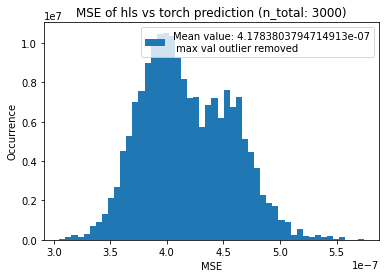

In [15]:
"""
Now let's graph the MSE distribution
"""
import numpy as np
import matplotlib.pyplot as plt

n_total = MSEs.shape[0]
mean_val = np.mean(MSEs)

plt.hist(MSEs, density=True, bins=50, label=f"Mean value: {mean_val}\n max val outlier removed") 
plt.ylabel('Occurrence')
plt.xlabel('MSE');
plt.title(f'MSE of hls vs torch prediction (n_total: {n_total})')
plt.legend()
plt.savefig('MSEs.png')

You can see from the graph above that the error is very small (order of magnitude -7). This will obviously get bigger once you use more realistic ap_fixed parameters, but this proves that the conversion itself is working as intended.

So this is the latest progress on the pyg to hls conversion. The current model is only one layer out of eight pyg layers from the original Siqi's model. More work is on the way, but hopefully this gives you a good idea of how the conversion pipeline works. 

For any questions, please email me at yun@purdue.edu, or slack if you already have me on it.
Thank you!

Biography: This walkthrough and other local files were taken from Mr Abd Elabd's code at https://github.com/abdelabd/manual_GNN_conversion